## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pytz
import warnings

mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=10)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', size=10)
%matplotlib inline

In [2]:
PATH= '/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
#PATH= '/results2/SalishSea/hindcast/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,1,1)
flen=1
namfmt='nowcast'
filemapP={'vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}


In [3]:
datelims=(dt.datetime(1900,1,1),dt.datetime(2100,1,1))
fdata=et.loadHakai(datelims,loadCTD=True)
fdata.head()

Note: CTD depths (pZ) may vary from bottle depths (Z) by up to  1.5  m.


,NO2+NO3 (uM),PO4,SiO2,dtUTC,Station,Lat,Lon,Z,SA,CT,pZ
0,17.528459,1.480,37.597988,2014-11-07 19:30:39,QU5,50.1183,-125.2122,0.0,26.161950,11.063901,0.977
1,19.534208,1.637,39.536296,2014-11-07 18:30:30,QU17,50.1200,-125.1300,0.0,26.653561,10.967601,0.959
2,20.243301,1.671,38.212329,2014-11-07 17:30:32,QU24,50.0300,-125.0800,0.0,27.444017,11.171578,0.940
3,19.414687,1.621,38.879558,2014-11-07 19:30:39,QU5,50.1183,-125.2122,5.0,27.139286,11.176216,4.860
4,19.728054,1.646,39.173135,2014-11-07 18:30:30,QU17,50.1200,-125.1300,5.0,26.902988,10.976844,4.895


In [4]:
fdata['AbsSal']=fdata['SA']
fdata['ConsT']=fdata['CT']
df1=fdata
df1['NO23']=df1['NO2+NO3 (uM)']
df1['Si']=df1['SiO2']

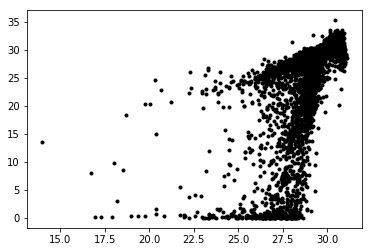

In [5]:
plt.plot(df1['SA'],df1['NO23'],'k.')

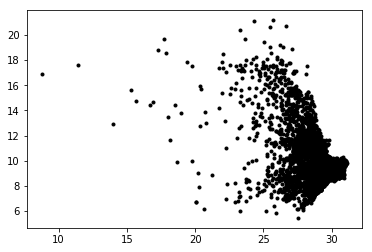

In [6]:
plt.plot(df1['SA'],df1['CT'],'k.')

In [7]:
df1.loc[(~np.isnan(df1.SA)),['SA']].count()

SA    3489
dtype: int64

In [8]:
df1.loc[(~np.isnan(df1.SA))&(np.isnan(df1.NO23)),['SA']].count()

SA    431
dtype: int64

In [9]:
df1.loc[(np.isnan(df1.SA))&(~np.isnan(df1.NO23)),['NO23']].count()

NO23    363
dtype: int64

In [10]:
df1.loc[~np.isnan(df1['CT']),['CT']].count()

CT    3489
dtype: int64

In [11]:
df1.loc[(~np.isnan(df1['CT']))&(np.isnan(df1.NO23)),['CT']].count()

CT    431
dtype: int64

In [12]:
df1.loc[(np.isnan(df1['CT']))&(~np.isnan(df1.NO23)),['NO23']].count()

NO23    363
dtype: int64

In [13]:
df1.loc[(~np.isnan(df1.NO23)),['NO23']].count()

NO23    3421
dtype: int64

In [14]:
print('% of N values without S:')
print(df1.loc[(np.isnan(df1.SA))&(~np.isnan(df1.NO23)),['NO23']].count().values/df1.loc[(~np.isnan(df1.NO23)),['NO23']].count().values*100)

% of N values without S:
[10.61093248]


In [15]:
list(df1)

['NO2+NO3 (uM)',
 'PO4',
 'SiO2',
 'dtUTC',
 'Station',
 'Lat',
 'Lon',
 'Z',
 'SA',
 'CT',
 'pZ',
 'AbsSal',
 'ConsT',
 'NO23',
 'Si']

In [16]:
# use only matched locs. 
df2=df1.loc[(df1.NO23>=0)|(df1.Si>=0),['Z', 'dtUTC', 'Station', 'Lat', 'Lon', 'SA', 'CT', 'pZ', 'AbsSal', 'ConsT']].copy(deep=True)

In [17]:
df2['Z']=df2['pZ']

In [18]:
dataHakaiPhys=et.matchData(df2,filemapP, fdict, start_date, end_date, namfmt, PATH, flen)
dataHakai=dataHakaiPhys

In [19]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [20]:
cm1=plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

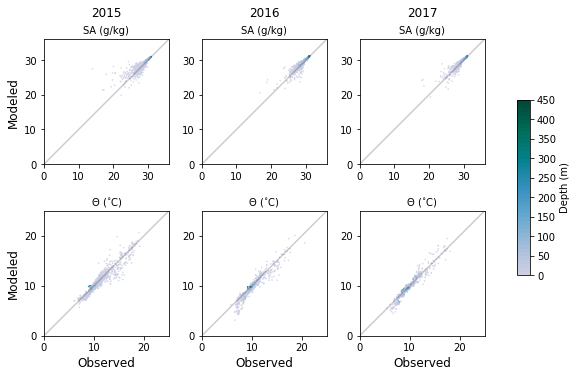

In [21]:
fig = plt.figure(figsize = (7.5,4.5))
gs1=gridspec.GridSpec(2,4,left=.08,right=.98,bottom=.015,top=.94,
                      wspace=.34,hspace=.34,height_ratios=[1,1],width_ratios=[1,1,1,.1])
ax2015N=fig.add_subplot(gs1[0,0])
ax2016N = fig.add_subplot(gs1[0,1])
ax2017N = fig.add_subplot(gs1[0,2])
ax2015Si= fig.add_subplot(gs1[1,0])
ax2016Si= fig.add_subplot(gs1[1,1])
ax2017Si= fig.add_subplot(gs1[1,2])
gscb=gridspec.GridSpecFromSubplotSpec(5,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

for ax in (ax2015N,ax2016N,ax2017N):
    ax.plot((0,36),(0,36),'k-',alpha=.2)
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.plot((0,25),(0,25),'k-',alpha=.2)

vm0=-150
args={'marker':'.','s':1,}
dataHakai2015=dataHakai.loc[(dataHakai.dtUTC>=dt.datetime(2015,1,1))&(dataHakai.dtUTC<dt.datetime(2016,1,1))]
ps=et.varvarScatter(ax2015N,dataHakai2015,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
dataHakai2016=dataHakai.loc[(dataHakai.dtUTC>=dt.datetime(2016,1,1))&(dataHakai.dtUTC<dt.datetime(2017,1,1))]
ps=et.varvarScatter(ax2016N,dataHakai2016,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
dataHakai2017=dataHakai.loc[(dataHakai.dtUTC>=dt.datetime(2017,1,1))&(dataHakai.dtUTC<dt.datetime(2018,1,1))]
ps=et.varvarScatter(ax2017N,dataHakai2017,'AbsSal','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2015Si,dataHakai2015,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2016Si,dataHakai2016,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(ax2017Si,dataHakai2017,'ConsT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

cb=fig.colorbar(ps,cax=axcb,boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')

ntick=np.arange(0,36,10)
ntickl=[str(i) for i in ntick]
for ax in (ax2015N,ax2016N,ax2017N):
    ax.set_xlim((0,36))
    ax.set_ylim((0,36))
    ax.set_xticks(ntick)
    ax.set_xticklabels(ntickl)
    ax.set_yticks(ntick)
    ax.set_yticklabels(ntickl)
    
stick=np.arange(0,25,10)
stickl=[str(i) for i in stick]
for ax in (ax2015Si,ax2016Si,ax2017Si):
    ax.set_xlim((0,25))
    ax.set_ylim((0,25))
    ax.set_xticks(stick)
    ax.set_xticklabels(stickl)
    ax.set_yticks(stick)
    ax.set_yticklabels(stickl)
    
for ax in (ax2015N,ax2016N,ax2017N,ax2015Si,ax2016Si,ax2017Si):
    ax.set_aspect(1, adjustable='box')
    #ax.set_xlabel('Observed')
    
ax2015N.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_ylabel('Modeled',fontsize=12)
ax2015Si.set_xlabel('Observed',fontsize=12)
ax2016Si.set_xlabel('Observed',fontsize=12)
ax2017Si.set_xlabel('Observed',fontsize=12)

ax2015N.annotate('2015',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2016N.annotate('2016',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2017N.annotate('2017',xy=[.5,1.18],xycoords='axes fraction',ha='center',fontsize=12)
ax2015N.set_title('SA (g/kg)')
ax2016N.set_title('SA (g/kg)')
ax2017N.set_title('SA (g/kg)')
ax2015Si.set_title('$\Theta$ ($^{\circ}$C)')
ax2016Si.set_title('$\Theta$ ($^{\circ}$C)')
ax2017Si.set_title('$\Theta$ ($^{\circ}$C)')


In [22]:
import pickle
pickle.dump(dataHakaiPhys,open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataHakaiPhys.pkl','wb'))